#### Calculate wind shear according to LMI and their climatology

 - wind shear at LMI locations
 - Climatology (July-Sept) of wind shear at those locations
 - histogram plot of distributins comparison

from James'  get_era5_shear_at_lmi.ncl

Ming Ge June 2024

In [1]:
import os
import calendar
import glob
import numpy as np
import xarray as xr
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from netCDF4 import Dataset

from tc_helping import hist_3, hist_4, latlon_ij, level_k

#### set up

In [8]:
lag = 0

#  averaging radius in degrees
rr = .5

year_s = 1980
year_e = 2021
n_year = year_e - year_s + 1

# climatology calculation only on July, Aug, Sept
months   = ['07', '08', '09']
last_day = ['31', '31', '30']
n_month = len(months)

# NA region:
lat_s = 5
lat_e = 60
lon_e = -10  
lon_s = -100

dir_plot = '/glade/campaign/mmm/c3we/mingge/ERA5/NA_RI/PLOT/'

#### read in lmi times/locations

In [9]:
flnm = '/glade/campaign/mmm/c3we/mingge/ERA5/NA_RI/RI_Instances.csv'
df_all = pd.read_csv(flnm, delimiter=',', engine='python')
tt = df_all['Start Time'].values
mm = []
for nm in range(len(tt)):
    mm.append(tt[nm][5:7])
mm = np.array(mm, dtype=int)

# for northern hemisphere, July, Aug. and Sept
df_lmi = df_all.loc[(df_all.lat.values >= lat_s) & (df_all.lat.values <= lat_e) &
                    (df_all.lon.values >= lon_s) & (df_all.lon.values <= lon_e) &
                    (mm >=7) & (mm <= 9)]
print(df_lmi.head())
tt = df_lmi['Start Time'].values
yyyy = []
mm = []
dd = []
hh = []
for nm in range(len(tt)):
    yyyy.append(tt[nm][:4])
    mm.append(tt[nm][5:7])
    dd.append(tt[nm][8:10])
    hh.append(tt[nm][11:13])

yyyy = np.array(yyyy, dtype=int)
mm = np.array(mm, dtype=int)
dd = np.array(dd, dtype=int)
hh = np.array(hh, dtype=int)

yyyys = yyyy.astype(str)
mms   = mm.astype(str)
dds   = dd.astype(str)
hhs   = hh.astype(str)

ntim = len(hhs)

yyyymmddhh = [None] * ntim
date_format = '%Y%m%d%H'

yyyymmddhh  = [None] * ntim
yyyymmddhhs = [None] * ntim
for nt in range(ntim):
    current_date = datetime(yyyy[nt], mm[nt], dd[nt], hh[nt])
    
    # Calculate the date of the previous 2 days
    datetime_lagged = current_date - timedelta(days=lag)
    yyyy[nt] = datetime_lagged.year
    mm[nt]   = datetime_lagged.month
    dd[nt]   = datetime_lagged.day
    hh[nt]   = datetime_lagged.hour
    
    yyyy[nt] = str(yyyy[nt]) 
    mms[nt]  = str(mm[nt]).zfill(2)
    mms[nt]  = str(mm[nt]).zfill(2)
    dds[nt]  = str(dd[nt]).zfill(2)
    hhs[nt]  = str(hh[nt]).zfill(2)
    yyyymmddhh[nt] = int(yyyys[nt] + mms[nt] + dds[nt] + hhs[nt]) 
    yyyymmddhhs[nt] = str(yyyymmddhh[nt])
    
# E5 is on a quarter degree lat lon. Need to round to the nearest quarter to get the same dimensions for compositing.
lat = np.round(df_lmi.lat.values*4.0, 0)/4.0
lon = df_lmi.lon.values
lon = np.where(lon <= 0., lon+360., lon)
lon = np.round(lon*4.0, 0)/4.0 
#vmax = df_lmi.Vmax.values
'lat:', lat.min(), '-', lat.max(), 'lon:',lon.min(), '-', lon.max()

   storm           Start Time             End Time  Vmax Change   lat   lon
0  ALLEN  1980-08-01 18:00:00  1980-08-02 18:00:00           30  10.7 -40.7
1  ALLEN  1980-08-02 00:00:00  1980-08-03 00:00:00           30  11.0 -42.8
2  ALLEN  1980-08-02 18:00:00  1980-08-03 18:00:00           35  12.3 -49.1
3  ALLEN  1980-08-03 00:00:00  1980-08-04 00:00:00           45  12.4 -51.4
4  ALLEN  1980-08-03 06:00:00  1980-08-04 06:00:00           45  12.6 -53.6


('lat:', 9.0, '-', 35.5, 'lon:', 263.0, '-', 342.5)

#### Calculate wind shear from ERA5

In [11]:
%%time
dir_era5 = "/glade/campaign/collections/rda/data/ds633.0/e5.oper.an.pl/"
dir_o = '/glade/campaign/mmm/c3we/mingge/ERA5/NA_RI/'
flnm_csv = dir_o + 'global_RI_e5_lag' + str(lag) + 'd_' + str(rr) + "radius_shear_NA.csv"
print('output', flnm_csv)

# identify K of level 850hPa and 200 hPa
flnm = dir_era5 + '197907/e5.oper.an.pl.128_131_u.ll025uv.1979070100_1979070123.nc'
i_1d, j_1d = latlon_ij(lat, lon, flnm)
k850 = level_k (850, flnm)
k200 = level_k (200, flnm)

pattern_u = 'e5.oper.an.pl.128_131_u.ll025uv*nc'  
pattern_v = "e5.oper.an.pl.128_132_v.ll025uv*nc"

if os.path.isfile(flnm_csv):
    print(flnm_csv, 'exist')
    df = pd.read_csv(flnm_csv, delimiter=',', engine='python')
    shear_lmi = df.shear
    print(shear_lmi)
else:
    shear = np.zeros((ntim))
    for nt in range(ntim):
        dir = dir_era5 + yyyys[nt] + mms[nt] + "/" 
        flnm_u = dir + "e5.oper.an.pl.128_131_u.ll025uv." + yyyys[nt] + mms[nt] + dds[nt] + "00_" + yyyys[nt] + mms[nt] + dds[nt] + "23.nc"
        print(nt, flnm_u)
        ncid = Dataset(flnm_u, mode='r')        
        U200 =  ncid.variables['U'][hh[nt], k200, i_1d[nt]-2:i_1d[nt]+3, j_1d[nt]-2:j_1d[nt]+3]
        U850 =  ncid.variables['U'][hh[nt], k850, i_1d[nt]-2:i_1d[nt]+3, j_1d[nt]-2:j_1d[nt]+3]
        ncid.close()
        
        flnm_v = dir + "e5.oper.an.pl.128_132_v.ll025uv." + yyyys[nt] + mms[nt] + dds[nt] + "00_" + yyyys[nt] + mms[nt] + dds[nt] + "23.nc"
        ncid = Dataset(flnm_v, mode='r')
        V200 =  ncid.variables['V'][hh[nt], k200, i_1d[nt]-2:i_1d[nt]+3, j_1d[nt]-2:j_1d[nt]+3]
        V850 =  ncid.variables['V'][hh[nt], k850, i_1d[nt]-2:i_1d[nt]+3, j_1d[nt]-2:j_1d[nt]+3]
        ncid.close()
         
        shear[nt] = (np.sqrt(np.square(U200-U850) + np.square(V200-V850))).mean()

    data = { 'yyyymmddhh': yyyymmddhhs, 'lat': lat, 'lon': lon, 'shear': shear}

    # Create the pandas DataFrame
    df = pd.DataFrame(data)
    df.to_csv(flnm_csv, float_format="%.3f", index=False) 


output /glade/campaign/mmm/c3we/mingge/ERA5/NA_RI/global_RI_e5_lag0d_0.5radius_shear_NA.csv
/glade/campaign/collections/rda/data/ds633.0/e5.oper.an.pl/197907/e5.oper.an.pl.128_131_u.ll025uv.1979070100_1979070123.nc
in /glade/campaign/collections/rda/data/ds633.0/e5.oper.an.pl/197907/e5.oper.an.pl.128_131_u.ll025uv.1979070100_1979070123.nc
in /glade/campaign/collections/rda/data/ds633.0/e5.oper.an.pl/197907/e5.oper.an.pl.128_131_u.ll025uv.1979070100_1979070123.nc
/glade/campaign/mmm/c3we/mingge/ERA5/NA_RI/global_RI_e5_lag0d_0.5radius_shear_NA.csv exist
0       5.570
1       4.709
2       3.727
3       4.326
4       5.288
        ...  
562    19.488
563    14.142
564    12.886
565    12.352
566    14.959
Name: shear, Length: 567, dtype: float64
CPU times: user 69.8 ms, sys: 3.19 ms, total: 73 ms
Wall time: 210 ms


#### 2 Calculate climatology

#### 3 histogram plot of distributins comparison

/glade/campaign/mmm/c3we/mingge/ERA5/NA_RI/PLOT/shear_distribution_NA_3.eps


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


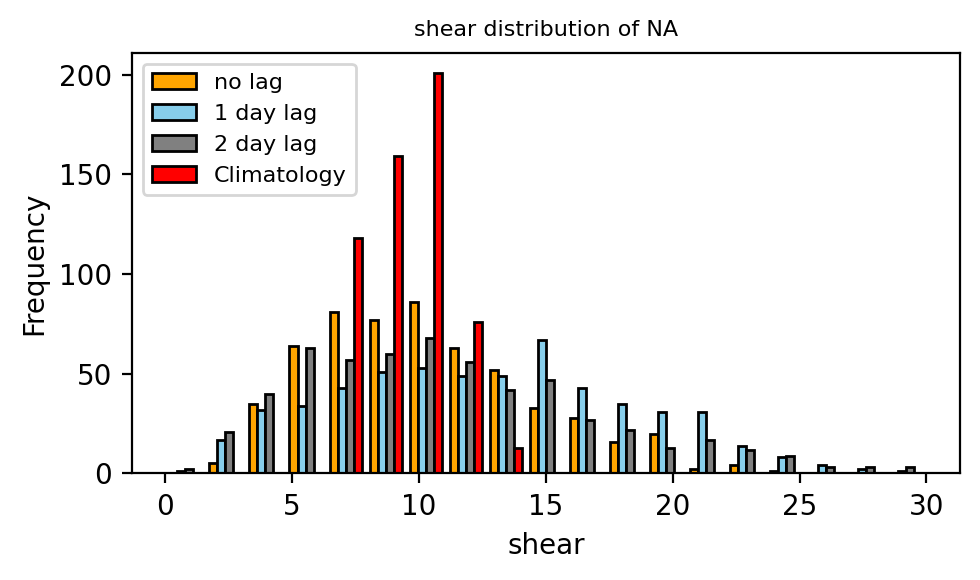

/glade/campaign/mmm/c3we/mingge/ERA5/NA_RI/PLOT/shear_diff_distribution_NA_3.eps


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


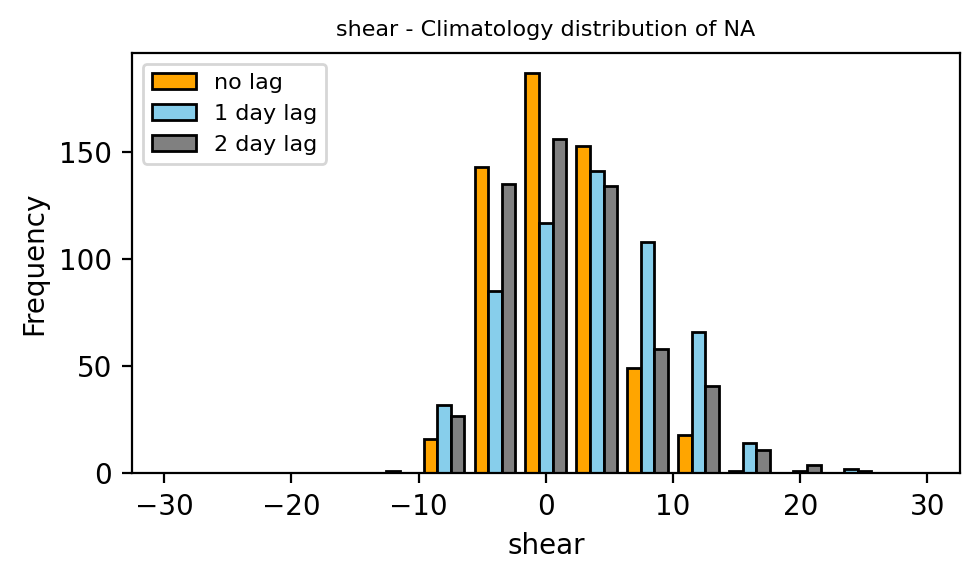

In [14]:
dir_cli = '/glade/campaign/mmm/c3we/mingge/ERA5/NA_CLI/'

shear_cli = np.zeros((ntim))
year_ss = 1990
year_ee = 2020

for year in range(year_ss, year_ee + 1):
    flnm_nc = dir_cli + 'global_lmi_e5_' + str(rr) + 'radius_shear_NA_'+ str(year) +'_July-Sep.nc'
    with xr.open_dataset(flnm_nc) as ds:
        if year == year_ss:
            shear_cli_2d = ds.shear
        else:
            shear_cli_2d = shear_cli_2d + ds.shear
        
shear_cli_2d = shear_cli_2d/float(n_year)

for nt in range(ntim):
    shear_cli[nt] = shear_cli_2d.sel(lat=slice(lat[nt]+rr, lat[nt]-rr), 
                        lon=slice(lon[nt]-rr,lon[nt]+rr)).mean()


flnm_csv = [dir_o + 'global_RI_e5_lag0d_0.5radius_shear_NA.csv',
            dir_o + 'global_RI_e5_lag1d_0.5radius_shear_NA.csv',
            dir_o + 'global_RI_e5_lag2d_0.5radius_shear_NA.csv']

bins = np.linspace(0, 30, 20)
hist_4(dir_plot, dir_o, 'shear', bins, flnm_csv, shear_cli)
bins = np.linspace(-30, 30, 16)
hist_3(dir_plot, dir_o, 'shear', bins, flnm_csv, shear_cli)
